![](http://img.khan.co.kr/news/2010/09/23/201009230061.jpg)
# **Titanic survive prediction**
- [https://www.kaggle.com/c/titanic](https://www.kaggle.com/c/titanic)

___
## **1. 개요**
Titanic survive prediction :
- [Titanic](https://www.kaggle.com/c/titanic)에서 수집한 과거 데이터를 이용하여, 탑승했던 승객들의 생존 여부 예측
- 문제 유형 : Classification

### **1.1. 문제 접근 방법**
- 이번 경진 대회에서는 891개의 학습용 데이터와 418개의 평가 데이터를 제공한다. 일부 변수들에 대한 결측치가 존재하며, EDA를 통해 사용여부를 판단한다.

1) 데이터 전처리 
- 결측값(NAN, nan)이 존재. 이러한 feature들을 전처리해서 사용할 것인지 판단 필요

2) FE 
- 범주형 변수의 이산화
- Family 변수 생성
    - SibSp(형제의 수) + Parch(부모의 수) + 1(본인) = Family 
- 결측치 대체를 위한 아이디어
- 연속형 변수에 대한 log scale 적용
    - tree 모델의 경우 변환할 필요가 없지만 치우친 분포를 변환하는 방법을 익히기 위함
    
3) 모델 생성
- base 모델은 SVM을 이용하고, 이에따른 전처리와 변환을 실시.
- 비교 모델로는 LGBM, XGBoost를 사용.

___
## **2. 팀 구성**
#### **팀원 소개**
| 이름 | 역할 | 
| :------------ | :-----------: | 
| 안 승 보 | 프로젝트 운영, base 모델 탐색, 생성| 
| 김 도 민 | Kernel 탐색, 데이터 전처리, FE 아이디어 제공 | 
| 조 수 빈 | 변수 정리, 데이터 시각화를 통한 데이터 탐색| 

___

## **3. 데이터 분석과정**

In [139]:
# python 라이브러리 호출
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pandas_summary import DataFrameSummary
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

In [2]:
# 데이터 불러오기
path = 'C:/Users/tmznq/workspace/ml_scratch/dataset/titanic/train.csv'
path2 = 'C:/Users/tmznq/workspace/ml_scratch/dataset/titanic/test.csv'
path3 = 'C:/Users/tmznq/workspace/ml_scratch/dataset/titanic/gender_submission.csv'
train = pd.read_csv(path)
test = pd.read_csv(path2)
submission = pd.read_csv(path3)

### **3.1. feature 탐색**
| feature | 정의 | 비고 | 
| :------------ | :-----------: | :-----------: | 
| Survival | 생존 여부 |	0 = No, 1 = Yes | 
| Pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd | 
| Sex |	성별	| 남, 여 | 
| Age | 나이 | 연속형 | 
| Sibsp | 동승한 형제의 수 |  | 
| Parch | 동승한 부모의 수 |  | 
| Ticket | Ticket number |  | 
| Fare | 요금 | 연속형 | 
| Cabin | Cabin number |  | 
| Embarked | 승선한 항구의 이름 | C = Cherbourg, Q = Queenstown, S = Southampton | 

___

### **3.2. 데이터 확인, 탐색적 데이터 분석(EDA)**

#### **학습 데이터 확인**

In [41]:
train[:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### **평가 데이터 확인**

In [157]:
test[:5]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


#### **데이터의 결측치, 빈도 수, 형식** 

In [83]:
DataFrameSummary(train).columns_stats

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial
counts,891,891,891,891,891,891,891,891,891,891,204,891,891
uniques,891,2,3,891,2,92,7,7,681,248,147,4,17
missing,0,0,0,0,0,0,0,0,0,0,687,0,0
missing_perc,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,77.10%,0%,0%
types,numeric,bool,numeric,unique,bool,numeric,numeric,numeric,categorical,numeric,categorical,numeric,categorical


In [211]:
DataFrameSummary(test).columns_stats

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial
counts,418,418,418,418,418,418,418,418,417,91,418,418
uniques,418,3,418,2,83,7,8,363,169,76,3,9
missing,0,0,0,0,0,0,0,0,1,327,0,0
missing_perc,0%,0%,0%,0%,0%,0%,0%,0%,0.24%,78.23%,0%,0%
types,numeric,numeric,unique,bool,numeric,numeric,numeric,categorical,numeric,categorical,categorical,categorical


- 결측치가 많은 변수(Cabin, Age)를 찾을 수 있었다.
- 학습데이터와 다르게 평가 데이터에서는 Fare에 일부 결측치가 존재한다.
- 범주형으로 사용할 변수지만 categorical이 아닌 경우(Pclass, Sex, Embarked, SibSp, Parch) 데이터 변환이 필요하다.

#### **범주형 변수와 생존 여부 시각화**

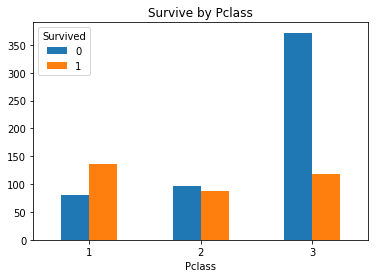

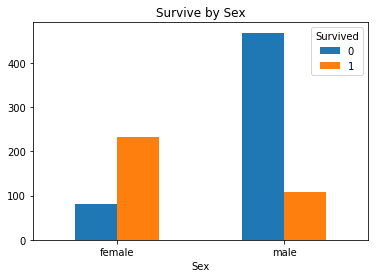

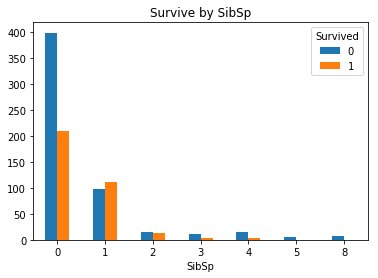

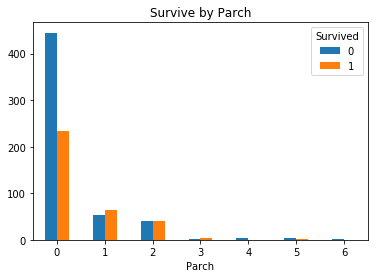

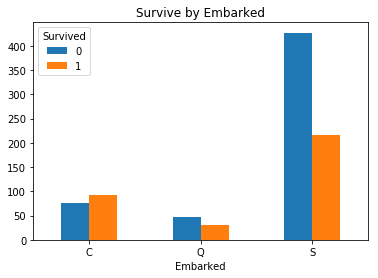

In [43]:
categorical_features = ['Pclass',
                        'Sex',
                        'SibSp',
                        'Parch',
                        'Embarked']

for feature in categorical_features:
        df = pd.crosstab(train['{}'.format(feature)], train.Survived)
        df.plot(kind='bar', title = 'Survive by {}'.format(feature), rot=0)

- Pclass
    - 3등급의 승객의 생존률은 낮고, 1등급의 경우 생존률이 높다.
- Sex
    - 남자의 생존률은 낮지만 여성의 경우 높다.
- SibSp
    - 동승하지 않은 경우 생존률이 낮다.
- Parch
    - 동승하지 않은 경우 생존률이 낮다.
- Embarked
    - S에서 탄 사람의 경우 생존률이 낮다.

#### **결측치 시각화**

Text(0.5, 1.0, 'Missing values in test dataset')

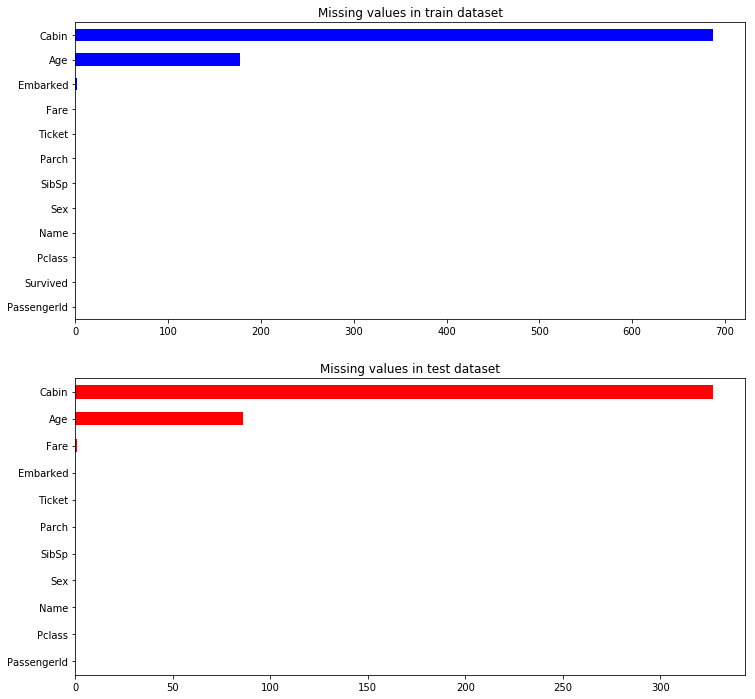

In [44]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

train.isna().sum().sort_values(ascending=True).plot(ax=axes[0], kind='barh',color='blue', fontsize=10)
axes[0].set_title('Missing values in train dataset')

test.isna().sum().sort_values(ascending=True).plot(ax=axes[1], kind='barh',color='red', fontsize=10)
axes[1].set_title('Missing values in test dataset')

- Cabin과 Age 변수는 학습 데이터와 평가 데이터 모두 결측치가 많이 존재함을 알 수 있다.
- 결측치가 많은 Cabin은 사용하지 않고, Age는 일단 결측치를 제거 후 데이터 확인에 사용한다.

In [45]:
# 결측치 제거
train.Age.dropna(inplace=True)
test.Age.dropna(inplace=True)

#### **연속형 변수의 분포 시각화**

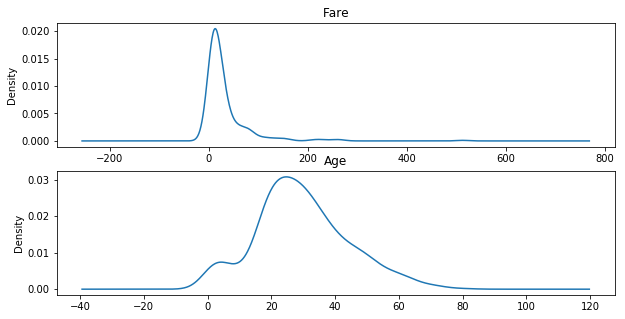

In [53]:
# 연속형 변수의 분포 시각화
fig, axes = plt.subplots(2,1, figsize=(10,5))

train.Fare.plot(kind='kde', ax = axes[0], title= 'Fare')
train.Age.plot(kind='kde', ax = axes[1], title= 'Age')

- Age의 경우 정규분포와 비슷한 분포를 가지지만, Fare의 경우 왼쪽으로 치우친, right longtail 모양의 분포를 가진다.
- tree 모델에서는 연속형 변수의 단위를 건드릴 필요가 없지만 SVM과 같은 거리에 영향을 받는 모델의 경우 치우친 분포를 가진 변수와 연속형 변수들의 단위는 모델에 영향을 미치므로 변환해줘야 한다.
___

### **3.3. 데이터 전처리, Feature Engineering(FE)**
- 데이터 탐색과정에서 데이터를 일부 건드렸으므로 kernel을 재시작하거나 데이터를 초기화하고 전처리와 FE 진행할 것.

In [217]:
# 데이터 초기화
train = pd.read_csv(path)
test = pd.read_csv(path2)
submission = pd.read_csv(path3)

#### **결측치 대체**

##### **Age의 NaN값 대체**
- 정규 표현식을 사용해서 Name의 성을 추출하고, 그에 따른 연령대 별 평균을 구하자.
- 평가 데이터의 NaN값은 학습 데이터의 값으로 대체해야한다.

In [218]:
# Name's title
# Age와 Name을 이용해서 Age의 NaN값을 대체하기 위한 정규표현식 이용하기.
train['Initial'] = train.Name.str.extract('([A-Za-z]+)\.')
test['Initial'] = test.Name.str.extract('([A-Za-z]+)\.')

In [219]:
# Initial에 따른 Age의 평균값으로 NaN값 대체
train['Age'] = train.groupby('Initial')['Age'].apply(lambda x: x.fillna(x.mean()))

# 학습 데이터의 평균값
Age_mean = train.groupby('Initial')['Age'].mean()

# test에도 동일하게 적용하지만, 학습 데이터의 평균값을 대입시켜 줄 것.
for name in set(train['Initial'].values):
    form_ = '{}'.format(name)
    test.loc[test['Initial'] == form_, 'Age'] = test.loc[test['Initial'] == form_, 'Age'].fillna(Age_mean[form_])

In [223]:
test[test.Age.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial


- 만약 중복되는 성이 없어 대체가 되지 않고, NaN값으로 남아 있는 값이 있었다면 train.Age.mean()로 대체하자.
- 다행히 그런 값은 없었으므로 넘어가자.

##### **Fare의 NaN값 대체**
- 학습 데이터의 Fare의 평균값으로 NaN값을 대체하자.
- 평가 데이터의 NaN값은 학습 데이터의 값으로 대체해야한다.

In [224]:
# 학습 데이터 Fare의 평균값
Fare_mean = train.Fare.mean()

# NaN값 대체
train[train.Fare.isnull()] = Fare_mean
test[test.Fare.isnull()] = Fare_mean

#### **범주형 데이터 전처리**

In [225]:
# Sex, Embarked 
train["Sex"]=np.where(train["Sex"]=="male",0,1)
train["Embarked"]=np.where(train["Embarked"]=="S",0,
                                  np.where(train["Embarked"]=="C",1,
                                           np.where(train["Embarked"]=="Q",2,3)
                                          )
                                 )
test["Sex"]=np.where(test["Sex"]=="male",0,1)
test["Embarked"]=np.where(test["Embarked"]=="S",0,
                                  np.where(test["Embarked"]=="C",1,
                                           np.where(test["Embarked"]=="Q",2,3)
                                          )
                                 )

#### 연속형 데이터 전처리

##### **Fare 단위 변환**
- log scale 적용
- 1을 더해주는 이유는 log를 취해줄 때, 0으로 무한히 가는 경우를 방지하기 위함

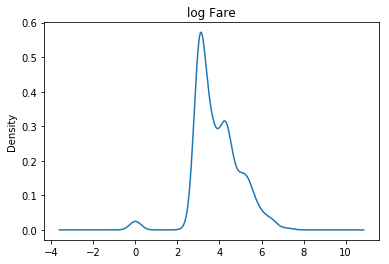

In [226]:
# Fare
train['Fare'] = train['Fare'].apply(lambda i: np.log(i) + 1 if i > 0 else 0)
test['Fare'] = test['Fare'].apply(lambda i: np.log(i) + 1 if i > 0 else 0)

train.Fare.plot(kind='kde', title= 'log Fare')

##### **연속형 변수 scale**

In [228]:
# scaler
scaler = StandardScaler()
# fitting
scaler.fit(train[['Fare', 'Age']])

# transforming
train[['Fare', 'Age']] = scaler.transform(train[['Fare', 'Age']])
test[['Fare', 'Age']] = scaler.transform(test[['Fare', 'Age']])

___
#### Family col 생성
- 동승한 형제의 수 + 동승한 부모의 수 + 1 = 가족 구성원 수로 정의할 수 있다.

In [229]:
# SibSp + Parch + 1 = Family
train['Family'] = train['SibSp'] + train['Parch'] + 1
test['Family'] = test['SibSp'] + test['Parch'] + 1

Text(0.5, 1.0, 'Survive by Family')

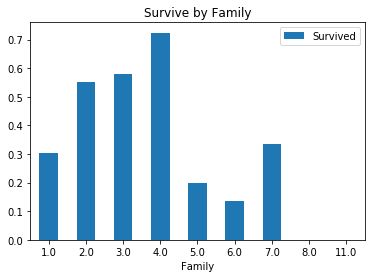

In [230]:
train[['Family', 'Survived']].groupby(by='Family').agg('mean').plot(kind= 'bar', rot=0)
plt.title('Survive by Family')

- 2~4인 가족의 경우 생존률이 50% 이상인 것을 알 수 있다.

___
### **3.4. ML 모델 생성**

#### 사용할 변수 설정

In [231]:
used_features =[
    "Pclass",
    "Sex",
    "Embarked",
    "Age",
    "Fare",
    "Family"]

#### 데이터 나누기

In [232]:
# Split dataset in training and test datasets
X_train, X_val, y_train, y_val = train_test_split(train[used_features], 
                                                    train.Survived, test_size=0.4, stratify = train['Survived'])

#### 모델 생성

In [255]:
svc = LinearSVC(max_iter=3000)
svc.fit(X_train, y_train)
print("{}".format(svc))
print("train set 정확도: {:.2f}".format(svc.score(X_train, y_train)))
print("val set 정확도: {:.2f}\n".format(svc.score(X_val, y_val)))

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=3000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
train set 정확도: 0.81
val set 정확도: 0.78



- train에 약간의 overfitting이 된 것으로 판단하고 모델 튜닝을 해보자.

#### 모델 튜닝

In [256]:
# parameter
params = {'loss': 'squared_hinge',
          'penalty': 'l2',
          'C': 1.0,
          'max_iter':10000
          }

svc.set_params(**params)
print("{}\n".format(svc))
print("훈련 세트 정확도: {:.2f}".format(svc.score(X_train, y_train)))
print("테스트 세트 정확도: {:.2f}\n".format(svc.score(X_val, y_val)))

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

훈련 세트 정확도: 0.81
테스트 세트 정확도: 0.78



___
### **3.5 결과 제출**

In [ ]:
svc.set_params(**params)
svc.fit(X_train, y_train)
y_pred = svc.predict(test[used_features])

In [259]:
# submission의 Survived column을 예측한 값으로 대체하기
submission.Survived = y_pred

In [261]:
# DataFrame -> csv 파일 저장
submission.to_csv('gender_submission.csv', index=False)

- 아래 업로드 하는 곳에다가 csv 형식으로 저장한 파일을 제출.
- [업로드 하는 곳](https://www.kaggle.com/c/titanic/submit)

___
## **4. 개선사항**
- LGMB, XGBoost를 이용해서 비교 모델을 만들어볼 것. 이는 kaggle의 [kernel](https://www.kaggle.com/c/titanic/kernels)에서 사용할 수 있는 GPU를 이용.
- 여러 모델을 만들고 앙상블 모델 생성해볼 것.